Se trabaja en colab, razon por la cual para subir un archivo se utiliza lo siguiente:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se suben las librerías necesarias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

Se utiliza el path de dirección de la imagen a utilizar en la simulación

In [3]:
image = plt.imread('/content/drive/MyDrive/u/Colab Notebooks/TICS/A.jpg')

In [4]:
image.shape #imagen guardada como n arrays (número de filas) que contienen los m arrays correspondientes al numero de 
             #columnas, donde cada uno porta la informacion de los canales RGB 

(371, 322, 3)

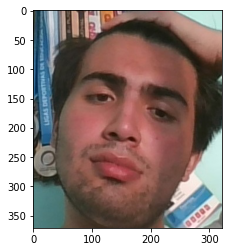

In [5]:
plt.imshow(image) #plot de imagen a utilizar

In [6]:
#dada una imagen retorna el valor de cada pixel para cada canal en un único arreglo por canal y las dimensiones de la imagen (altura y ancho)
def canales_rgb(imagen): 
  canal1=[]
  canal2=[]
  canal3=[]
  sizes=[len(imagen),len(imagen[0])]
  for i in range(len(imagen)): # alto imagen
    for j in range(len(imagen[0])): #largo imagen ->
      canal1.append(imagen[i][j][0])
      canal2.append(imagen[i][j][1])
      canal3.append(imagen[i][j][2])
  return canal1,canal2,canal3,sizes


In [7]:
c1,c2,c3,size = canales_rgb(image) #cada canal de imagen en un vector plano

In [8]:
#Dado un arreglo por canal y las dimensiones de la imagen reconstruye el tensor de la imagen
def armar_imagen(canal1,canal2,canal3,sizes): 
  pos = 0
  imagen = np.zeros((sizes[0],sizes[1],3))
  for i in range(sizes[0]):
    for j in range(sizes[1]):
      imagen[i][j] = [int(canal1[pos]),int(canal2[pos]),int(canal3[pos])]
      pos+=1
  imagen = imagen.astype(np.int32)
  return imagen

In [9]:
imagagen = armar_imagen(c1,c2,c3,size)

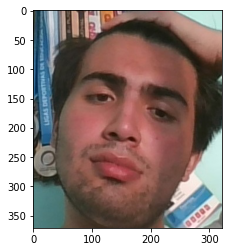

In [10]:
plt.imshow(imagagen)

In [11]:
#Convertir numero decimal a binario (8 bits)
def numero_binario(numero):
    return "{0:08b}".format(numero)

#Convertir arreglo de numeros decimales a arreglo de numeros binarios 
def canal_a_binario(canal):
    empty_array= canal
    for i in range(len(canal)):
        empty_array[i] = numero_binario(canal[i])
    return empty_array

In [12]:
#Convertir el numero binario a decimal
def binario_decimal(binario):
    return int(binario, 2)#.astype(np.int32)

#Convertir arreglo de numeros binarios a decimal
def binario_a_decimal(arreglo):
    empty_array= arreglo
    for i in range(len(arreglo)):
        empty_array[i] = binario_decimal(arreglo[i])
    return empty_array

In [13]:
c1_bin = canal_a_binario(c1)
c2_bin = canal_a_binario(c2)
c3_bin = canal_a_binario(c3)

In [14]:
c1_bin[:6]

['10110001', '01010111', '00111001', '00111011', '00111101', '00110110']

In [15]:
#Convierte arreglo de numeros binarios a arreglos de subarreglos de 32 elementos, si para el ultimo subarreglo faltan valores se rellena con 0 en binario
def to_packet(canal):
  packets = np.resize(canal,((len(c1)//32+1),32))
  indice = 31-(len(packets)*32-len(canal))
  for i in range(32):
    if i> indice:
      packets[-1][i] = '00000000'
  return packets

In [16]:
msj1 = to_packet(c1_bin)
msj2 = to_packet(c2_bin)
msj3 = to_packet(c3_bin)

In [17]:
msj1[0][:6]

array(['10110001', '01010111', '00111001', '00111011', '00111101',
       '00110110'], dtype='<U8')

In [18]:
#una vez estan todos los paquetes guardados de forma ordenada en un array, lo convierte en el canal correspondiente para reconstruir la imagen 
def to_channel(packets,size1,size2):
  packetacanal = np.resize(packets,len(packets)*len(packets[0]))
  packetacanal = packetacanal[:size1*size2]
  packetacanal = binario_a_decimal(packetacanal)
  return packetacanal

In [19]:
msj1acannal = to_channel(msj1,size[0],size[1])
msj2acannal = to_channel(msj2,size[0],size[1])
msj3acannal = to_channel(msj3,size[0],size[1])

In [20]:
imagencarretiada = armar_imagen(msj1acannal,msj2acannal,msj3acannal,size)


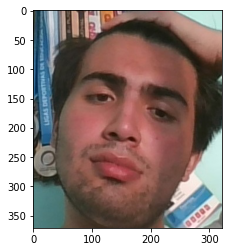

In [21]:
plt.imshow(imagencarretiada)

Dado el objetivo de la simulacion solo importan parametros del paquete origen(o)-destino(d)-SEQ(s)-ACK(a)-Data(D), utilizando para direccion de destino y origen las asignadas por IPV4. En la simulación por tanto se omitatirán partes del header tales como: traffic class,flowlabel,pay load length,nextheader,hoplimit, ya que si bien su implementación a la hora de aplicar las comunicaciones es necesaria, para la simulación no aportan mayor información.

Se define la clase packet, la cual se encarga de componer los paquetes a enviar con los parametros anteriornmente mencionados

In [22]:
#largo_data = 32 #fijo para data en 32 bytes

class Packet(): #inventamos el paquete en si
    def __init__(self,seq,ack,origin,destiny,data):
        self.ipversion = '0100'
        self.seq = seq
        self.ack = ack
        self.origin = origin
        self.destiny = destiny
        self.data = data



In [23]:
class Send_packet():
  def __init__(self, ack, state=True):
    self.ack = ack            
    self.prob = 0   # probabilidad de pérdida del segmento en porcentaje
    self.state = state      # estado que indica si se perdió o no
  
  def send(self):
    """ Método que envía el segmento con probabilidad de pérdida entre 1 y 10% con saltos de 1 en 1"""
    num_random = random.randint(1, 100)
    self.prob = num_random
    if num_random <= 10:
      self.state = False

class Receive_packet():
  def __init__(self,ip, acks=[], packets=[]):        
    self.ip = ip 
    self.acks = acks 
    self.packets = packets

  def ack_check(self, ack):
    self.acks.append(ack)       # guarda identificador del ack 

  def packet_received(self,packet):
      self.packets.append(packet)

  def clearack(self):
    self.acks.clear()
  
  def clearpacket(self):
    self.packets.clear()


In [24]:
16515615%6

3

In [25]:
def TCPreno1( packets_received, rtt):
  ssthresh = 32
  CW=[1] 
  ack_counter = 1   #SI LLEGA A 3 HUBO PERDIDA
  
  for i in range(len(packets_received.acks)): 
    if CW[-1] <= ssthresh:
      cwnd= 2**(i%7)
      CW.append(cwnd)
  
    if  CW[-1] > ssthresh:
      cwnd=CW[-1]
      if packets_received.acks[i-1] != packets_received.acks[i]:
        cwnd+=1
        CW.append(cwnd)
      else:
        ack_counter += 1

  
    if ack_counter == 3:
        ack_counter = 1
        cwnd = CW[-1] // 2
        CW.append(cwnd)

    RTT=[i*rtt for i in range(1,len(CW)+1)]

    if RTT[-1]%120 == 0: #TIMEOUT
        cwnd=1
        CW.append(cwnd)
  return RTT, CW

In [26]:
packet_tamano_img = canal_a_binario(size)

In [27]:
packet_tamano_img

['101110011', '101000010']

In [28]:
last_array= []
for i in range(32):
  last_array.append('00000000')

last_array[0]=packet_tamano_img[0]
last_array[1]=packet_tamano_img[1]

#last_array # ultimo paquete; contiene la informacion de ancho y alto de imagen

In [29]:
#ip pc 1 -> 1.5.11.2
#ip pc 2 -> 13.13.13.13

packetstosend = [] #paquetes que van del host inicial al router 1
origen = numero_binario(1)+numero_binario(5)+numero_binario(11)+numero_binario(2)
destino = numero_binario(13)+numero_binario(13)+numero_binario(13)+numero_binario(13)



for i in range(len(msj1)):

  seq = numero_binario(i)
  ack = numero_binario(i)
  packet = Packet(seq, ack,origen,destino, msj1[i])
  packetstosend.append(packet)

for j in range(len(msj2)):

  seq = numero_binario(j+len(msj1))
  ack = numero_binario(j+len(msj1))
  packet = Packet(seq, ack,origen,destino, msj2[j])
  packetstosend.append(packet)

for k in range(len(msj3)):

  seq = numero_binario(k+len(msj1)+len(msj2))
  ack = numero_binario(k+len(msj1)+len(msj2))
  packet = Packet(seq, ack,origen,destino, msj3[k])
  packetstosend.append(packet)

seq += numero_binario(k+len(msj1)+len(msj2)+len(msj3)+1)
ack += numero_binario(k+len(msj1)+len(msj2)+len(msj3)+1)
packet = Packet(seq, ack,origen,destino, last_array)
packetstosend.append(packet)



In [30]:
print(f'Numero de packetes a enviar {len(packetstosend)}')

Numero de packetes a enviar 11203


#Modelado de TCP

In [31]:
iprouter1 = numero_binario(0)+numero_binario(0)+numero_binario(0)+numero_binario(1)
iprouter2 = numero_binario(0)+numero_binario(0)+numero_binario(0)+numero_binario(2)
iprouter3 = numero_binario(0)+numero_binario(0)+numero_binario(0)+numero_binario(3)

In [32]:
router1 = Receive_packet(iprouter1)
router1.clearack()
router1.clearpacket()

#modelado de envio de pc1 y recepcion de router 1 

for i in range(len(packetstosend)):
    enviopc1 = Send_packet(binario_decimal(packetstosend[i].ack))
    enviopc1.send()

    if enviopc1.state == False:
        for a in range(3):
            router1.ack_check(i)
    else:
        router1.ack_check(enviopc1.ack)
    router1.packet_received(packetstosend[i]) #DISCLAIMER esto debería relacionarse con seq y estar dentro del else para simular aun mejor, pero dada la carga 
                                              #de final de semestre no se pudo

In [33]:
packets_received_router1 = router1.packets.copy() #paquetes que van del router 1 al router2
acks_router1 = router1.acks.copy()
RTT1, CW1 = TCPreno1(router1 , 1)

In [34]:
router2 = Receive_packet(iprouter2)
router2.clearack()
router2.clearpacket()

#modelado de envio de router 1 y recepcion de router 2 

for i in range(len(packets_received_router1)):
    enviorouter1 = Send_packet(binario_decimal(packets_received_router1[i].ack))
    enviorouter1.send()

    if enviorouter1.state == False:
        for a in range(3):
            router2.ack_check(i)
    else:
        router2.ack_check(enviorouter1.ack)
    router2.packet_received(packets_received_router1[i])

In [35]:
packets_received_router2 = router2.packets.copy() #paquetes que van del router 1 al router2
acks_router2 = router2.acks.copy()
RTT2, CW2 = TCPreno1(router2 , 1)

In [36]:
router3 = Receive_packet(iprouter3)
router3.clearack()
router3.clearpacket()

#modelado de envio de router 1 y recepcion de router 2 

for i in range(len(packets_received_router2)):
    enviorouter2 = Send_packet(binario_decimal(packets_received_router2[i].ack))
    enviorouter2.send()

    if enviorouter2.state == False:
        for a in range(3):
            router3.ack_check(i)
    else:
        router3.ack_check(enviorouter2.ack)
    router3.packet_received(packets_received_router2[i])

In [37]:
packets_received_router3 = router3.packets.copy() #paquetes que van del router 1 al router2
acks_router3 = router3.acks.copy()
RTT3, CW3 = TCPreno1(router3 , 1)

In [38]:
pc2 = Receive_packet(destino)
pc2.clearack()
pc2.clearpacket()

#modelado de envio de router 1 y recepcion de router 2 

for i in range(len(packets_received_router3)):
    enviorouter3 = Send_packet(binario_decimal(packets_received_router3[i].ack))
    enviorouter3.send()

    if enviorouter3.state == False:
        for a in range(3):
            pc2.ack_check(i)
    else:
        pc2.ack_check(enviorouter3.ack)
    pc2.packet_received(packets_received_router3[i])

In [39]:
packets_final = pc2.packets.copy() #paquetes que van del router 1 al router2
acks_pc2 = router3.acks.copy()
RTT4, CW4 = TCPreno1(pc2 , 1)

Text(0, 0.5, 'Window size')

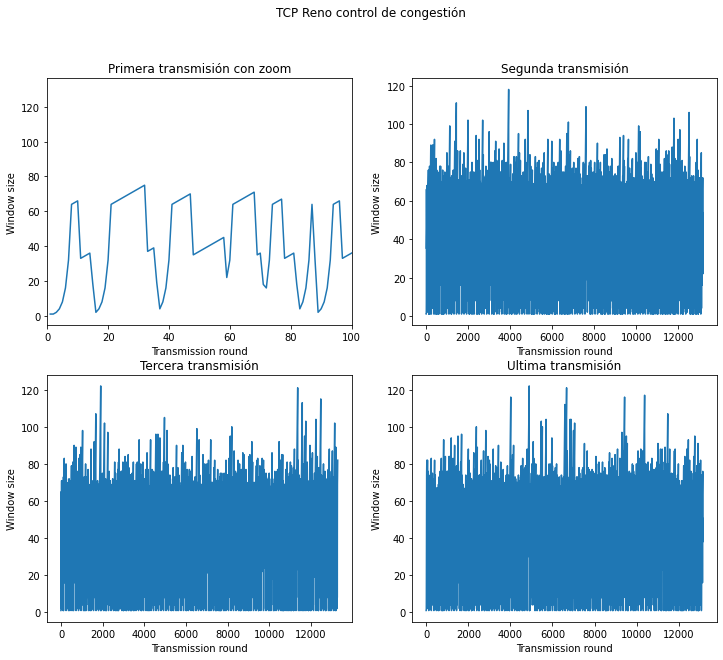

In [40]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
fig.suptitle('TCP Reno control de congestión')
axs[0, 0].plot(RTT1,CW1)
axs[0, 0].set_title('Primera transmisión con zoom')
axs[0, 0].set_xlabel('Transmission round')
axs[0, 0].set_ylabel('Window size')
axs[0, 0].set_xlim(0, 100)
axs[0, 1].plot(RTT2,CW2)
axs[0, 1].set_title('Segunda transmisión')
axs[0, 1].set_xlabel('Transmission round')
axs[0, 1].set_ylabel('Window size')
axs[1, 0].plot(RTT3,CW3)
axs[1, 0].set_title('Tercera transmisión')
axs[1, 0].set_xlabel('Transmission round')
axs[1, 0].set_ylabel('Window size')
axs[1, 1].plot(RTT4,CW4)
axs[1, 1].set_title('Ultima transmisión')
axs[1, 1].set_xlabel('Transmission round')
axs[1, 1].set_ylabel('Window size')

In [41]:
print(f'packetes recibidos p1 {len(packets_received_router1)}')
print(f'packetes recibidos p2 {len(packets_received_router2)}')
print(f'packetes recibidos p3 {len(packets_received_router3)}')
print(f'packetes recibidos p4 {len(packets_final)}')

packetes recibidos p1 11203
packetes recibidos p2 11203
packetes recibidos p3 11203
packetes recibidos p4 11203


Para recodificar todo el mensaje lo primero es ver las dimensiones de la imagen, las cuales se especifican en el ultimo bloque

In [ ]:
binario_a_decimal(packets_final[-1].data)

En este caso 371x322 pixeles, para cada canal, como la transmision era de 32 elementos se divide 371*322 entre 32, usando la funcion piso, ya que cabe la posibilidad de transmitir un bloque que no este completo, este resultado + 1 debe dar la cantidad de bloques de data transmitidos, siendo el +1 correspondiente al bloque que envia la informacion del tamano de imagen

In [ ]:
(371*322//32+1)*3+1
packets_final

In [44]:
canal1final=[]
for i in range(371*322//32+1):
  canal1final.append(packets_final[i].data)

In [45]:
canal2final=[]
for i in range(371*322//32+1,2*(371*322//32+1)):
  canal2final.append(packets_final[i].data)

In [46]:
canal3final=[]
for i in range(2*(371*322//32+1),3*(371*322//32+1)):
  canal3final.append(packets_final[i].data)

In [47]:
print(f'Len canal 1 final {len(canal1final)}')
print(f'Len canal 2 final {len(canal2final)}')
print(f'Len canal 3 final {len(canal3final)}')


Len canal 1 final 3734
Len canal 2 final 3734
Len canal 3 final 3734


In [48]:
canalR = to_channel(canal1final,371,322)
canalG = to_channel(canal2final,371,322)
canalB = to_channel(canal3final,371,322)

In [49]:
imagen_destinofinal = armar_imagen(canalR,canalG,canalB,[371,322])

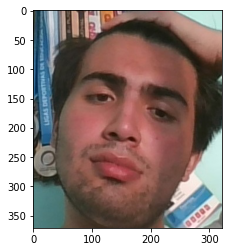

In [50]:
plt.imshow(imagen_destinofinal)